In [3]:
import numpy as np 
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

from torchvision.models.detection import ssd300_vgg16


import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

loss_df = pd.DataFrame(columns=['loss'])
loss_df

,loss


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(21)
torch.manual_seed(21)

test = [0,2,14,17,28,29,30]

Small data set of 50 images. The full 400+ images can be run in train_bccd.ipynbd

*Warning this can take a LONG time locally to run depending on you computer specifications.


In [5]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='BCCD/', trans=None):
        super()
        self.root = root
        self.pds = pd.read_csv("BCCD_small/test.csv")
        self.clases = ['Bachground'] + list(self.pds.cell_type.unique())
        self.clases_idx = {w: i for i, w in enumerate(self.clases)}
        self.transforms = tv.transforms.Compose([
               # tv.transforms.Resize([300, 300]),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()
        
    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'JPEGImages',filename)).convert("RGB")
        return img
    
    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.clases_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

In [6]:
# Run this to reset the model and effectively unlearn!

model = ssd300_vgg16(pretrained = True).to(device) # weights='DEFAULT',
ds=BCCDDataset()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
eps = 2
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn)
    i = 0
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(25):
            if i >= len(perm):
                break
            p,t = ds[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 5 + pred['classification']
        loss.backward()
        trainer.step()  
        l1+=pred['bbox_regression'].item()
        l2+=pred['classification'].item()
        l0+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    pc = (ep + 1) / eps
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' % 
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln))

 0m 36s (-  0m 36s) ( 0  50%)   1.3534   0.4327   0.4173


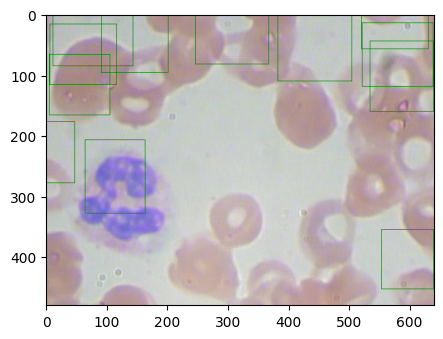

In [71]:
model.eval()
p,t = ds[0]
total = 0
correct = 0
outputs = model([p])
img = ds.get_image(i)
draw = ImageDraw.Draw(img)
classes = outputs[0]['labels'].cpu().numpy()
scores = outputs[0]['scores'].detach().cpu().numpy()
boxes = outputs[0]['boxes'].detach().cpu().numpy()

# Check the score of the result.
for i,box in enumerate(boxes):
    if scores[i] > 0.5 :
        c = classes[i]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
plt.figure(figsize=(5, 5))
plt.imshow(img)

In [8]:

model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
eps = 1
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn)
    i = 0
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(25):
            if i >= len(perm):
                break
            p,t = ds[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 5 + pred['classification']
        loss.backward()
        trainer.step()  
        l1+=pred['bbox_regression'].item()
        l2+=pred['classification'].item()
        l0+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    pc = (ep + 1) / eps 
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' % 
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln))

 0m  5s (-  0m  0s) ( 0 100%)  32.8242   1.9180  14.4305


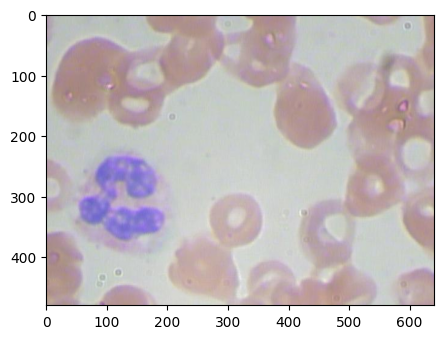

In [9]:
model.eval()
p,t = ds[0]
outputs = model([p])
img = ds.get_image(i)
draw = ImageDraw.Draw(img)
classes = outputs[0]['labels'].cpu().numpy()
scores = outputs[0]['scores'].detach().cpu().numpy()
boxes = outputs[0]['boxes'].detach().cpu().numpy()

for i,box in enumerate(boxes):
    if scores[i] > 0.5 :
        c = classes[i]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
plt.figure(figsize=(5, 5))
plt.imshow(img)

In [10]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
#Modify this to determine how many EPOCHS
eps = 20
trn=list(set(range(len(ds)))-set(test))

#Iterrate and start learning using the bounding box paramaters.
for ep in range(eps):
    perm = np.random.permutation(trn)
    i = 0
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(25):
            if i >= len(perm):
                break
            p,t = ds[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 5 + pred['classification']
        loss.backward()
        trainer.step()  
        l1+=pred['bbox_regression'].item()
        l2+=pred['classification'].item()
        l0+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    pc = (ep + 1) / eps 
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' % 
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln)) 

 0m  5s (-  1m 46s) ( 0   5%)  19.5572   1.5785   7.0989
 0m 10s (-  1m 34s) ( 1  10%)  10.0675   1.1622   3.3136
 0m 16s (-  1m 31s) ( 2  15%)   9.1529   1.1163   2.9226
 0m 21s (-  1m 26s) ( 3  20%)   6.2157   0.7500   3.4033
 0m 26s (-  1m 19s) ( 4  25%)   4.9442   0.6929   2.5439
 0m 32s (-  1m 15s) ( 5  30%)   4.4487   0.6417   2.3900
 0m 38s (-  1m 10s) ( 6  35%)   3.8013   0.5691   2.1821
 0m 43s (-  1m  5s) ( 7  40%)   3.2969   0.5049   2.0221
 0m 49s (-  1m  0s) ( 8  45%)   3.0021   0.4610   1.9394
 0m 54s (-  0m 54s) ( 9  50%)   2.8070   0.4302   1.8817
 1m  0s (-  0m 49s) (10  55%)   2.5811   0.3974   1.7914
 1m  5s (-  0m 43s) (11  60%)   2.3865   0.3634   1.7261
 1m 11s (-  0m 38s) (12  65%)   2.2247   0.3306   1.6781
 1m 16s (-  0m 32s) (13  70%)   2.0603   0.3010   1.6073
 1m 21s (-  0m 27s) (14  75%)   1.9123   0.2756   1.5326
 1m 26s (-  0m 21s) (15  80%)   1.8074   0.2550   1.4822
 1m 31s (-  0m 16s) (16  85%)   1.7238   0.2384   1.4395
 1m 36s (-  0m 10s) (17  90%)  

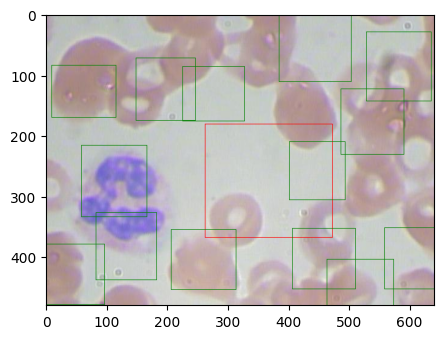

In [11]:
# This is where we use what the model learnt above to try and draw some boxes around the different types of cells.

model.eval()
p,t = ds[0]
outputs = model([p])
img = ds.get_image(i)
draw = ImageDraw.Draw(img)
classes = outputs[0]['labels'].cpu().numpy()
scores = outputs[0]['scores'].detach().cpu().numpy()
boxes = outputs[0]['boxes'].detach().cpu().numpy()

for i,box in enumerate(boxes):
    if scores[i] > 0.5 :
        c = classes[i]
        c = c if c < 4 else 0
        cl = ['black','red','green','blue']
        draw.rectangle(xy=box.tolist(), outline=cl[c])
plt.figure(figsize=(5, 5))
plt.imshow(img)